In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from IPython.display import Image
np.set_printoptions(precision = 3)

In [2]:
data = pd.read_csv("jester-data-1.csv", header=None)
#del data["0"]
#d = data.to_latex()
#text_file = open("Output_lab4_test.txt", "w")
#text_file.write(d)
#text_file.close()

In [3]:
#text_file.close()data.columns
del data[data.columns[0]]

In [4]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [5]:
user_ratings = data.values
#user_ratings = data.values[0:100]

In [6]:
user_ratings_vali = np.zeros(user_ratings.shape) + 99.0
user_ratings_copy = user_ratings.copy() 
count = 0
loc_log = []
for x in range(0,user_ratings.shape[0]):
    for y in range(0,user_ratings.shape[1]):
        if (user_ratings_copy[x,y]!=99.0):
            if (np.random.random() > 0.9):
                count += 1
                temp = user_ratings_copy[x,y]
                user_ratings_copy[x,y] = user_ratings_vali[x,y]
                user_ratings_vali[x,y] = temp
                loc_log.append((x,y))
                #print(temp)
print(user_ratings_vali,'\n', count,'\n', count/(user_ratings.shape[0]*user_ratings.shape[1]))

[[99.   99.   99.   ... 99.   99.   99.  ]
 [ 4.08 99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]
 ...
 [99.   99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]] 
 181073 
 0.07247848537005164


In [7]:
len(loc_log)

181073

In [8]:
n_features = 100
latent_user_preferences = np.random.random((user_ratings.shape[0], n_features))
latent_item_features = np.random.random((user_ratings.shape[1],n_features))

In [9]:
print('user_ratings.shape:           ',user_ratings.shape)
print('latent_user_preferences.shape:',latent_user_preferences.shape)
print('latent_item_features.shape:   ',latent_item_features.shape)

user_ratings.shape:            (24983, 100)
latent_user_preferences.shape: (24983, 100)
latent_item_features.shape:    (100, 100)


In [10]:
user_ratings, user_ratings.shape

(array([[-7.82,  8.79, -9.66, ..., 99.  , 99.  , 99.  ],
        [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        ...,
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        [ 2.43,  2.67, -3.98, ..., 99.  , 99.  , 99.  ]]), (24983, 100))

In [11]:
np.random.random()

0.9956226733819145

In [14]:
train_mse_loglist = []
test_mse_loglist = []
best_latent_user_preferences = latent_user_preferences.copy()
best_latent_item_features = latent_item_features.copy()
best_test_mse = 99999.0
best_loc = 0

In [15]:
def predict_rating(user_id,item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)  #linear

def train(user_id, item_id, rating,alpha = 0.0001):
    
    #print (item_id)
    prediction_rating = predict_rating(user_id, item_id)
    err =  ( prediction_rating- rating );
    #print (err)
    user_pref_values = latent_user_preferences[user_id][:]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    


def sgd(iterations = 300000):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    global best_latent_user_preferences
    global best_latent_item_features
    global best_test_mse
    global best_loc
    err_mse_log = 99999.0
    for iteration in range(0,iterations):
        error = []
        vali_err = []
        for user_id in range(0,latent_user_preferences.shape[0]):
            for item_id in range(0,latent_item_features.shape[0]):
                rating = user_ratings_copy[user_id][item_id]
                if(rating != 99):
                    err = train(user_id,item_id,rating)
                    error.append(err)
                    #print(rating)
        mse = (np.array(error) ** 2).mean()
        train_mse_loglist.append(mse)
        err_mse = mse - err_mse_log
        #if (err_mse>0):
        #    print(mse, err_mse, err_mse_log)
        #    break
        err_mse_log = mse
        for loc in loc_log:
            vali_err.append(user_ratings_vali[loc[0]][loc[1]]-latent_user_preferences[loc[0]].dot(latent_item_features[loc[1]]))
        test_mse = (np.array(vali_err) ** 2).mean()
        test_mse_loglist.append(test_mse)
        if (test_mse < best_test_mse):
            best_test_mse = test_mse
            best_latent_user_preferences = latent_user_preferences.copy()
            best_latent_item_features = latent_item_features.copy()
            best_loc = iteration
        if (iteration > best_loc+100):
            break
        #print(iteration)
        #if(iteration%100 == 0 ):
        print (iteration, ':=', mse, err_mse, test_mse)

In [16]:
sgd()

0 := 32.74729001717842 -99966.25270998281 25.337046059235025
1 := 25.22342908064655 -7.523860936531872 25.210955868427295
2 := 25.062581588250982 -0.16084749239556828 25.116832249544245
3 := 24.937013525890773 -0.1255680623602089 25.039902182426637
4 := 24.82979264338573 -0.10722088250504314 24.96831264952023
5 := 24.72678947709868 -0.1030031662870492 24.89087011740501
6 := 24.61421719380199 -0.11257228329668933 24.795213643740112
7 := 24.476614280354788 -0.13760291344720343 24.666218992606087
8 := 24.295199391510813 -0.1814148888439746 24.484799658145356
9 := 24.047027486875535 -0.24817190463527794 24.22782917924738
10 := 23.706101392700127 -0.3409260941754084 23.870681191132306
11 := 23.248329970814527 -0.4577714218855995 23.3943620964031
12 := 22.66188707133286 -0.5864428994816677 22.79780306783882
13 := 21.96106918922963 -0.7008178821032303 22.11062080519555
14 := 21.194846777362766 -0.7662224118668632 21.394755985218605
15 := 20.437864486050138 -0.7569822913126281 20.7255594984774

KeyboardInterrupt: 

In [17]:
del train_mse_loglist[0]

In [18]:
best_loc

48

In [19]:
import seaborn as sns

In [20]:
plotdata1 = DataFrame(np.vstack((np.arange(np.array(train_mse_loglist).shape[0]), train_mse_loglist)).T, columns=['iterations', 'train_MSE'])

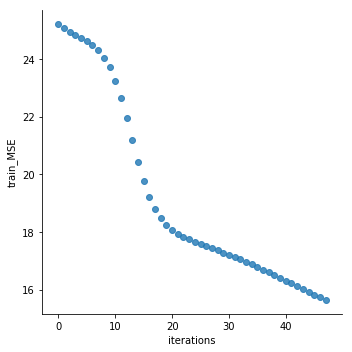

In [21]:
sns_plot = sns.lmplot(plotdata1.columns[0], plotdata1.columns[1], data=plotdata1, fit_reg=False)
sns_plot.savefig("Fulltext_predictions_trainMSE_%df_%d.png"%(n_features, best_loc), bbox_inches='tight')
sns_plot

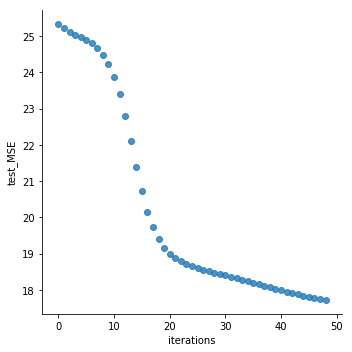

In [22]:
plotdata1 = DataFrame(np.vstack((np.arange(np.array(test_mse_loglist).shape[0]), test_mse_loglist)).T, columns=['iterations', 'test_MSE'])
sns_plot = sns.lmplot(plotdata1.columns[0], plotdata1.columns[1], data=plotdata1, fit_reg=False)
sns_plot.savefig("Fulltext_predictions_testMSE_%df_%d.png"%(n_features, best_loc), bbox_inches='tight')
sns_plot

In [23]:
min(test_mse_loglist), test_mse_loglist.index(min(test_mse_loglist)), train_mse_loglist[test_mse_loglist.index(min(test_mse_loglist))+1]

IndexError: list index out of range

In [24]:
min(train_mse_loglist), train_mse_loglist.index(min(train_mse_loglist)),

(15.637802425130607, 47)

In [25]:
latent_user_preferences

array([[0.966, 0.636, 0.213, ..., 0.301, 0.611, 0.08 ],
       [0.596, 0.172, 0.629, ..., 0.691, 0.624, 0.391],
       [0.148, 0.464, 0.614, ..., 0.272, 0.526, 0.738],
       ...,
       [0.85 , 0.821, 0.751, ..., 0.828, 0.292, 0.906],
       [0.573, 0.708, 0.497, ..., 0.874, 0.724, 0.777],
       [0.689, 0.146, 0.65 , ..., 0.458, 0.26 , 1.088]])

In [26]:
predictions = best_latent_user_preferences.dot(best_latent_item_features.T)
predictions

array([[-3.155, -2.179, -5.795, ..., -0.436, -6.772, -2.016],
       [ 5.174,  4.014,  4.677, ...,  0.917,  3.47 ,  1.919],
       [ 9.286,  9.67 , 10.693, ...,  8.411,  8.494,  8.976],
       ...,
       [ 0.876, -1.647, -0.348, ..., -1.438, -2.105, -1.186],
       [-0.827, -0.361, -1.671, ...,  1.123, -3.216,  0.763],
       [ 3.132,  3.985,  3.405, ...,  4.019,  3.63 ,  3.504]])

In [27]:
err = []
for t in range(0, len(loc_log)):
    #print(predictions[loc_log[t][0],loc_log[t][1]], best_latent_user_preferences[loc_log[t][0]].dot(best_latent_item_features[loc_log[t][1]]), user_ratings_vali[loc_log[t][0]][loc_log[t][1]])
    err.append(best_latent_user_preferences[loc_log[t][0]].dot(best_latent_item_features[loc_log[t][1]])-user_ratings_vali[loc_log[t][0]][loc_log[t][1]])
mse2 = (np.array(err) ** 2).mean()
print(mse2)

17.723704596539722


In [28]:
vali_err = []
for loc in loc_log:
    vali_err.append(user_ratings_vali[loc[0]][loc[1]]-best_latent_user_preferences[loc[0]].dot(best_latent_item_features[loc[1]]))
test_mse = (np.array(vali_err) ** 2).mean()
print (test_mse)

17.723704596539722


In [29]:
best_test_mse

17.723704596539722

In [30]:
values = [zip(user_ratings_copy[i], predictions[i]) for i in range(0,predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data.applymap(lambda x: "(%2.3f|%2.3f)"%(x[0],x[1]))
#comparison_data.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,(-7.820|-3.155),(8.790|-2.179),(-9.660|-5.795),(-8.160|-5.306),(-7.520|-2.395),(-8.500|-3.367),(-9.850|-3.660),(4.170|-2.116),(-8.980|-9.211),(-4.760|-6.239),...,(2.820|-3.291),(99.000|-3.714),(99.000|-1.224),(99.000|-8.435),(99.000|-4.438),(99.000|-5.284),(-5.630|-4.119),(99.000|-0.436),(99.000|-6.772),(99.000|-2.016)
1,(99.000|5.174),(-0.290|4.014),(6.360|4.677),(4.370|2.718),(-2.380|1.185),(-9.660|1.582),(99.000|0.873),(-5.340|1.720),(99.000|6.220),(9.220|4.782),...,(2.820|4.889),(-4.950|4.279),(-0.290|3.541),(7.860|4.437),(-0.190|4.756),(-2.140|4.253),(3.060|2.550),(0.340|0.917),(-4.320|3.470),(1.070|1.919)
2,(99.000|9.286),(99.000|9.670),(99.000|10.693),(99.000|8.028),(9.030|5.570),(99.000|8.320),(9.030|4.791),(9.270|2.182),(99.000|8.233),(99.000|8.867),...,(99.000|8.674),(99.000|6.695),(99.000|9.012),(9.080|7.190),(99.000|7.442),(99.000|7.291),(99.000|6.564),(99.000|8.411),(99.000|8.494),(99.000|8.976)
3,(99.000|2.028),(8.350|2.534),(99.000|2.529),(99.000|2.475),(1.800|1.376),(8.160|4.033),(-2.820|1.956),(6.210|-1.133),(99.000|0.102),(1.840|0.798),...,(99.000|3.474),(99.000|2.609),(99.000|4.810),(0.530|1.312),(99.000|3.304),(99.000|2.349),(99.000|3.215),(99.000|5.480),(99.000|2.369),(99.000|5.142)
4,(8.500|2.374),(4.610|4.756),(-4.170|2.953),(-5.390|1.207),(1.360|2.246),(1.600|4.310),(7.040|1.588),(4.610|-0.283),(-0.440|0.895),(5.730|3.345),...,(99.000|2.885),(5.580|2.643),(4.270|3.947),(5.190|0.821),(5.730|1.781),(1.550|1.909),(3.110|2.028),(6.550|4.281),(1.800|1.667),(1.600|5.644)
5,(-6.170|-3.199),(-3.540|-5.373),(0.440|-4.096),(-8.500|-7.655),(-7.090|-4.301),(-4.320|-6.364),(-8.690|-3.377),(-0.870|-1.189),(-6.650|-4.599),(-1.800|-2.136),...,(-3.540|-2.271),(-6.890|-4.591),(-0.680|-3.458),(99.000|-3.773),(-2.180|-4.467),(-3.350|-3.877),(0.050|-3.428),(-9.080|-5.490),(-5.050|-5.072),(99.000|-5.877)
6,(99.000|2.103),(99.000|1.779),(99.000|4.148),(99.000|1.878),(8.590|1.304),(99.000|6.121),(99.000|-0.052),(99.000|-1.852),(99.000|3.573),(99.000|3.496),...,(99.000|7.712),(99.000|7.085),(99.000|6.695),(99.000|5.316),(99.000|4.686),(2.330|5.421),(99.000|4.387),(99.000|4.215),(99.000|4.050),(99.000|4.332)
7,(6.840|0.620),(3.160|-0.377),(9.170|-0.352),(-6.210|-3.432),(-8.160|-2.181),(-1.700|-2.381),(9.270|-1.116),(1.410|-2.980),(-5.190|-3.259),(-4.420|-1.281),...,(7.230|-0.932),(-1.120|-3.973),(-0.100|-3.547),(-5.680|-3.204),(-3.160|-3.581),(-3.350|-3.238),(2.140|-2.500),(-0.050|-1.683),(1.310|-5.416),(0.000|-1.139)
8,(-3.790|-3.224),(-3.540|-3.126),(-9.420|-2.465),(-6.890|-2.702),(99.000|-1.295),(-0.290|0.377),(-5.290|-2.656),(-8.930|-2.481),(-7.860|-4.188),(-1.600|-2.548),...,(4.370|1.179),(-0.290|0.615),(4.170|2.029),(-0.290|-2.750),(-0.290|-0.727),(-0.290|-0.929),(-0.290|-1.685),(-0.290|0.800),(-3.400|-1.682),(99.000|1.633)
9,(3.010|5.253),(5.150|7.418),(99.000|6.451),(3.010|5.228),(6.410|5.333),(5.150|3.591),(8.930|6.171),(2.520|2.030),(3.010|2.386),(8.160|5.202),...,(99.000|4.917),(4.470|5.185),(99.000|5.006),(99.000|3.717),(99.000|4.599),(99.000|3.908),(99.000|4.102),(99.000|6.675),(99.000|2.268),(99.000|7.482)


In [ ]:
values = [zip(user_ratings_vali[i], predictions[i]) for i in range(0,predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data.applymap(lambda x: ["(%2.3f|%2.3f)"%(x[0],x[1])])

In [ ]:
mse

In [ ]:
predictions

In [ ]:
latent_item_features

In [ ]:

np.savetxt("Fulltext_predictions_%df_%d.csv"%(n_features, best_loc), predictions, delimiter=",")
np.savetxt("Fulltext_latent_user_preferences_%df_%d.csv"%(n_features, best_loc), best_latent_user_preferences, delimiter=",")
np.savetxt("Fulltextlatent_item_features_%df_%d.csv"%(n_features, best_loc), best_latent_item_features, delimiter=",")